In [1]:
%%capture
%matplotlib inline
import sys
sys.path.insert(1, './PoseCNN-PyTorch/lib')
from datasets.factory import get_dataset
from fcn.config import cfg, cfg_from_file, yaml_from_file, get_output_dir
from ycb_renderer import YCBRenderer
import torch
import numpy as np
import torch
import torch.nn.parallel 
import torch.backends.cudnn as cudnn 
import networks
from utils.nms import *
import matplotlib.pyplot as plt
from utils.blob import pad_im, chromatic_transform, add_noise
from transforms3d.quaternions import mat2quat, quat2mat
from utils.se3 import *
from utils.pose_error import *
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 9]
from scipy.spatial.transform import Rotation as R

from ProgressNerf.Dataloading.YCBVideoDataloader import YCBVideoDataloader
# import ProgressNerf.Dataloading.ToolsPartsDataloader

import ProgressNerf.Raycasting.VoxelGridBBoxRaysampler
import ProgressNerf.Raycasting.RandomRaypicker
import ProgressNerf.Raycasting.NearFarRaysampler
import ProgressNerf.Raycasting.WeightedRaypicker
import ProgressNerf.Raycasting.PerturbedRaysampler

import ProgressNerf.NeuralRendering.NeuralRenderer
# import ProgressNerf.NeuralRendering.VoxelNeuralRenderer

import ProgressNerf.Encoders.PositionalEncoder

# import ProgressNerf.Models.OGNerf
# from ProgressNerf.Architectures.OGNerfArch import OGNerfArch
import ProgressNerf.Models.FastNerf
from ProgressNerf.Architectures.VoxelGridCachedNerf import VoxelGridCachedNerf

from ProgressNerf.Utils.CameraUtils import BuildCameraMatrix
from fcn.train import loss_cross_entropy, smooth_l1_loss

# Create YCB Renderer

In [2]:
%%capture
cfg_from_file("./PoseCNN-PyTorch/experiments/cfgs/ycb_object.yml")
meta = yaml_from_file("./PoseCNN-PyTorch/data/demo/meta.yml")
dataset = get_dataset("ycb_object_test")
cfg.renderer = YCBRenderer(width=cfg.TRAIN.SYN_WIDTH, height=cfg.TRAIN.SYN_HEIGHT, gpu_id=1, render_marker=False)

libEGL warning: DRI2: failed to create dri screen
libEGL warning: DRI2: failed to create dri screen
Unable to initialize EGL
libEGL warning: DRI2: failed to create dri screen
libEGL warning: DRI2: failed to create dri screen
Unable to initialize EGL


In [3]:
print(dataset._intrinsic_matrix)

[[524.79178858   0.         332.52132328]
 [  0.         489.35639608 281.23398552]
 [  0.           0.           1.        ]]


# Create configuration & load meshes

In [4]:
%%capture
if cfg.TEST.SYNTHESIZE:
    cfg.renderer.load_objects(dataset.model_mesh_paths, dataset.model_texture_paths, dataset.model_colors)
else:
    model_mesh_paths = [dataset.model_mesh_paths[i-1] for i in cfg.TEST.CLASSES[1:]]
    model_texture_paths = [dataset.model_texture_paths[i-1] for i in cfg.TEST.CLASSES[1:]]
    model_colors = [dataset.model_colors[i-1] for i in cfg.TEST.CLASSES[1:]]
    cfg.renderer.load_objects(model_mesh_paths, model_texture_paths, model_colors)

cfg.renderer.set_camera_default()
cfg.TEST.POSE_REFINE = False
cfg.TEST.VISUALIZE = False 

cfg.MODE = 'TRAIN'

cfg.gpu_id = 0
cfg.device = torch.device('cuda:{:d}'.format(cfg.gpu_id))
cfg.instance_id = 0

number of devices found 5
Loaded EGL 1.5 after reload.


In [5]:
dataset.num_classes

21

# Setup Dataloader & Metadata

In [6]:
worker_init_fn = dataset.worker_init_fn if hasattr(dataset, 'worker_init_fn') else None
num_workers = 0 if cfg.TRAIN.SYNTHESIZE else 4
dataloader = torch.utils.data.DataLoader(dataset, 
                    batch_size=1,  #cfg.TRAIN.IMS_PER_BATCH, 
                    shuffle=True, 
                    num_workers=num_workers, 
                    worker_init_fn=worker_init_fn)

# Set meta_data 
K = dataset._intrinsic_matrix
K[2, 2] = 1
Kinv = np.linalg.pinv(K)
meta_data = np.zeros((1, 18), dtype=np.float32)
meta_data[0, 0:9] = K.flatten()
meta_data[0, 9:18] = Kinv.flatten()
meta_data = torch.from_numpy(meta_data).cuda()

# Load PoseCNN Network

In [7]:
%%capture
pretrained = "./PoseCNN-PyTorch/data/checkpoints/ycb_object/vgg16_ycb_object_self_supervision_epoch_8.checkpoint.pth"
pretrained = "./PoseCNN-PyTorch/data/checkpoints/ycb_video/vgg16_ycb_video_epoch_16.checkpoint.pth"

# cfg.TRAIN.FREEZE_LAYERS = False
network_data = torch.load(pretrained)
network = networks.__dict__["posecnn"](dataset.num_classes, 64, network_data).cuda()
network = torch.nn.DataParallel(network, device_ids=[cfg.gpu_id]).cuda()
cudnn.benchmark = True
network.eval()

# Create NeRF Model & Render Test

In [8]:
def toSE3Matrix(rotation, offset):
    mat = np.eye(4)
    if len(rotation) == 4:
        mat[0:3,0:3] = R.from_quat(np.concatenate((rotation[1:4], [rotation[0]]))).as_matrix()
    elif len(rotation.shape) == 2:
        mat[0:3,0:3] = rotation
    mat[0:3,3] = np.array(offset)
    return mat

In [9]:
def get_test_pose():    # TODO: remove
    quat = np.array([0.28405447470305767, 0.7107763388551345, 0.5857394722169705, -0.26649450690745147])
    offset = np.array([0.052757302998853915, -0.2394366825095671, 2.0026748131467889])
    return toSE3Matrix(quat, offset)

In [10]:
config_file = "./ycbVideo_Soup.yml"
arch = VoxelGridCachedNerf(config_file)
test_pose = get_test_pose()
test_cam_pose = np.linalg.inv(test_pose)
test_poses = torch.cat((torch.Tensor(test_cam_pose).unsqueeze(0),), dim = 0)

loading config at ./ycbVideo_Soup.yml
parsing config
initializing optimizer
loading model  & optimizer params from /home/stanlew/Documents/ProgressNerfModels/ycb_video/soup_can_6/epoch_200
resuming training from epoch 201...


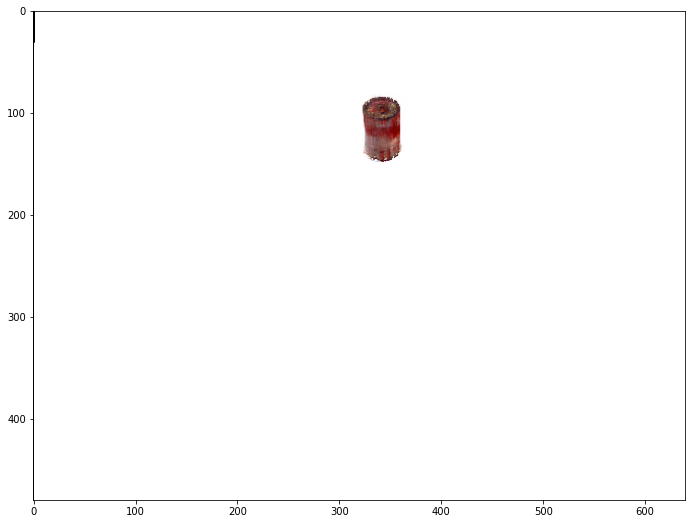

In [11]:
renderings = arch.doFullRender(test_poses, use_cache=True)
nerf_rgb = renderings['rgb'].contiguous().reshape((1, 640, 480, 3)).transpose(1,2).contiguous()
plt.imshow(nerf_rgb.cpu().squeeze().numpy())

# Run PoseCNN

In [12]:
def run_net(network, inputs, sample, meta_data, dataset):
    # prepare data
    inputs.cuda()
    # inputs = sample['image_color'].cuda()
    im_info = sample['im_info']
    mask = sample['mask'].cuda()
    labels = sample['label'].cuda()
    meta_data = sample['meta_data'].cuda()
    extents = sample['extents'][0, :, :].repeat(cfg.TRAIN.GPUNUM, 1, 1).cuda()
    gt_boxes = sample['gt_boxes'].cuda()
    poses = sample['poses'].cuda()
    points = sample['points'][0, :, :, :].repeat(cfg.TRAIN.GPUNUM, 1, 1, 1).cuda()
    symmetry = sample['symmetry'][0, :].repeat(cfg.TRAIN.GPUNUM, 1).cuda()
    if cfg.TRAIN.VERTEX_REG:
        vertex_targets = sample['vertex_targets'].cuda()
        vertex_weights = sample['vertex_weights'].cuda()
    else:
        vertex_targets = []
        vertex_weights = []
    return network(inputs, labels, meta_data, extents, gt_boxes, poses, points, symmetry)

In [13]:
def get_loss(network_results):
    # compute output
    if cfg.TRAIN.VERTEX_REG:
        if cfg.TRAIN.POSE_REG:
            out_logsoftmax, out_weight, out_vertex, out_logsoftmax_box, \
                bbox_labels, bbox_pred, bbox_targets, bbox_inside_weights, loss_pose_tensor, poses_weight \
                = network_results

            loss_label = loss_cross_entropy(out_logsoftmax, out_weight)
            loss_vertex = cfg.TRAIN.VERTEX_W * smooth_l1_loss(out_vertex, vertex_targets, vertex_weights)
            loss_box = loss_cross_entropy(out_logsoftmax_box, bbox_labels)
            loss_location = smooth_l1_loss(bbox_pred, bbox_targets, bbox_inside_weights)
            loss_pose = torch.mean(loss_pose_tensor)
            loss = loss_label + loss_vertex + loss_box + loss_location + loss_pose
        else:
            out_logsoftmax, out_weight, out_vertex, out_logsoftmax_box, \
                bbox_labels, bbox_pred, bbox_targets, bbox_inside_weights \
                = network_results

            loss_label = loss_cross_entropy(out_logsoftmax, out_weight)
            loss_vertex = cfg.TRAIN.VERTEX_W * smooth_l1_loss(out_vertex, vertex_targets, vertex_weights)
            loss_box = loss_cross_entropy(out_logsoftmax_box, bbox_labels)
            loss_location = smooth_l1_loss(bbox_pred, bbox_targets, bbox_inside_weights)
            loss = loss_label + loss_vertex + loss_box + loss_location
    else:
        out_logsoftmax, out_weight = network_results
        loss = loss_cross_entropy(out_logsoftmax, out_weight)
    return loss

torch.Size([1, 3, 480, 640])
dict_keys(['image_color', 'image_depth', 'im_depth', 'label', 'mask', 'mask_depth', 'meta_data', 'poses', 'extents', 'points', 'symmetry', 'gt_boxes', 'im_info', 'vertex_targets', 'vertex_weights'])
torch.Size([1, 3, 480, 640])
(tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.int32), tensor([[[[ 0.8983,  0.8983,  0.8983,  ..., -0.1515, -0.1515, -0.1515],
          [ 0.8983,  0.8983,  0.8983,  ..., -0.1515, -0.1515, -0.1515],
          [ 0.8983,  0.8983,  0.8983,  ..., -0.1515, -0.1515, -0.1515],
          ...,
          [-0.2854, -0.2854, -0.2854,  ..., -0.7132, -0.7132, -0.7132],
          [-0.2854, -0.2854, -0.2854,  ..., -0.7132, -0.7132, -0.7132],
          [-0.2854, -0.2854, -0.2854,  ..., -0.7132, -0.7132, -0.7132]],

         [[-0.1344, -0.1344, -

/home/stanlew/anaconda3/envs/nerfrenemy/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


RuntimeError: CUDA out of memory. Tried to allocate 1.07 GiB (GPU 0; 7.79 GiB total capacity; 2.33 GiB already allocated; 1.08 GiB free; 2.70 GiB reserved in total by PyTorch)

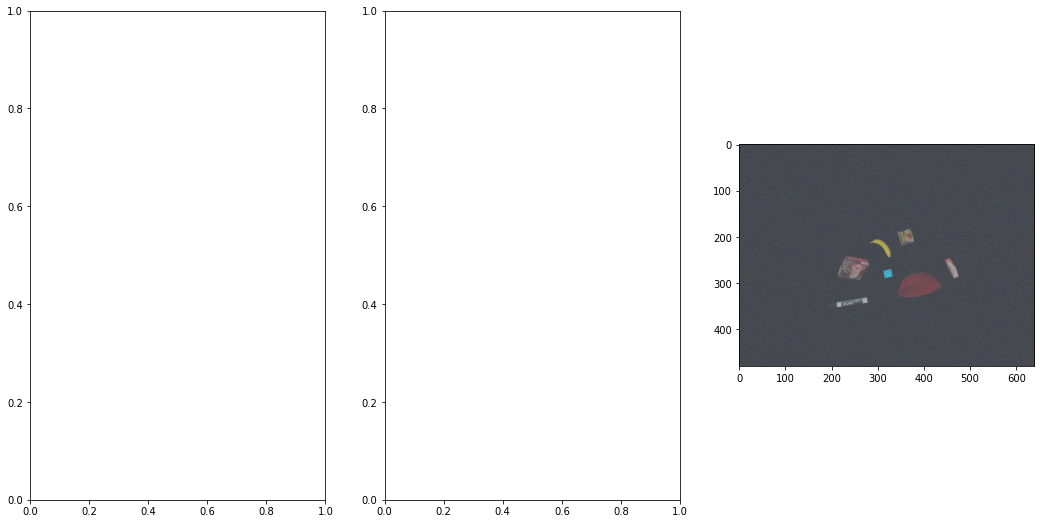

In [15]:
inputs = nerf_rgb.permute(0, 3, 1, 2).contiguous()
print(inputs.shape)
ycb_datapoint = next(iter(dataloader))
fig, axs = plt.subplots(1,3)
print(ycb_datapoint.keys())
print(ycb_datapoint['image_color'].shape)
axs[2].imshow(((ycb_datapoint['image_color'] + 1.0) / 2.0).squeeze().permute(1, 2, 0).detach().cpu().numpy()[:,:,::-1])

with torch.enable_grad():
    network.eval()
    initial_inputs = inputs.clone().detach()
    optimizer = torch.optim.Adam([inputs])
    optimizer.zero_grad()
    inputs.requires_grad=True
    network_results = run_net(network, inputs, ycb_datapoint, meta_data, dataset)
    print(network_results)
    pred_quaterion = network_results[-1]
    
    # NOTE: This is obviously just to prove gradients flow.  
    pred_quaterion.sum().backward()
    for i in range(1000): optimizer.step()   

    # Visualize
    #fig, axs = plt.subplots(1,2)
    axs[0].imshow(((inputs+1.0)/2).squeeze().permute(1, 2, 0).detach().cpu().numpy())
    axs[1].imshow(((initial_inputs+1.0)/2).squeeze().permute(1, 2, 0).detach().cpu().numpy())
    print("diff:  ", (initial_inputs - inputs).abs().sum())
    plt.show()
    print("HALT")

# Create DataLoader 

In [ ]:
config_dict = { "baseDataDir": "/home/stanlew/data/ycb-video/tool-parts_dataset/",\
               "scenes": ["0036","0037","0044","0060","0066","0068","0076","0079","0087","0089"],\
               "datasetType": "train",\
               "samplesLimit": 5,\
               "rel_tools": ["04"]}
dataloader = YCBVideoDataloader(config_dict)

In [ ]:
for batch_ndx, sample in enumerate(dataloader):
    image = sample['image']
    
    raise exception("stopping to print")